In [70]:
%matplotlib notebook
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [284]:
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime
import random
import torch.distributions as dist

import sys
sys.path.append("..")
from replay_buffer import ReplayBuffer

In [72]:
# %matplotlib qt5

#### Pytorch中Normal分布的sample()和rsample()的核心区别在于梯度传播方式
- sample()：直接从分布中采样，是不可微分的操作
- rsample()：使用重参数化技巧(reparameterization trick)，通过标准正太噪声+参数变换实现采样，是可以微分的

##### 1. 数学原理
假设我们有正态分布$\mathcal{N}(\mu, \sigma^2)$
- sample()：直接从目标分布采样$z \sim \mathcal{N}(\mu, \sigma^2)$
- rsample()：先采样标准正态噪声$\epsilon \sim \mathcal{N}(0, 1)$，再通过变换得到目标样本$z = \mu + \sigma \cdot \epsilon$

##### 2. 梯度传播
- sample()：采样过程是随机的，梯度无法通过采样步骤反向传播
- rsample()：梯度可以通过变换公式直接传播到参数$\mu$和$\sigma$

##### 3. 适用场景
- sample()：仅用于需要随机样本但不关心参数梯度的场景
- rsample()：适用于需要对分布参数求梯度的情况，如变分自编码器 (VAE)、强化学习等

In [73]:
import torch.distributions as dist

# 创建正态分布
mu = torch.tensor([0.0], requires_grad=True)
sigma = torch.tensor([1.0], requires_grad=True)
normal = dist.Normal(mu, sigma)

def test_sample(dist):
    # 报错
    # 使用sample() - 不可微分
    z_sample = dist.sample()
    loss_sample = (z_sample**2).sum()
    loss_sample.backward()
    return mu.grad, sigma.grad

def test_rsample(dist):
    # 使用rsample() - 可微分
    z_rsample = dist.rsample()
    loss_rsample = (z_rsample**2).sum()
    loss_rsample.backward()
    # mu.grad 和 sigma.grad 都有值
    return mu.grad, sigma.grad

test_rsample(normal)
# test_sample(normal)

(tensor([1.5682]), tensor([1.2296]))

## SAC网络

In [275]:
class Actor(nn.Module):
    def __init__(self, n_state, n_action, action_bound, hidden_size = 64):
        super(Actor, self).__init__()
        
        self.fc1 = torch.nn.Linear(n_state, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc_mean = torch.nn.Linear(hidden_size, n_action)
        self.fc_std = torch.nn.Linear(hidden_size, n_action)

        self.action_bound = action_bound

    def forward(self, state):
        x = self.fc1(state)
        x = self.fc2(F.relu(x))
        mu = self.fc_mean(F.relu(x))
        std = F.softplus(self.fc_std(F.relu(x)))

        normal_dist = dist.Normal(mu, std)
        sample = normal_dist.rsample()
        log_prob = normal_dist.log_prob(sample)

        action = torch.tanh(sample)
        # 修正tanh带来的概率密度变化，确保策略梯度正确
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-6)
        action = action * self.action_bound
        return action, log_prob

        
class Qvalue(nn.Module):
    def __init__(self, n_state, n_action, hidden_size=64):
        super(Qvalue, self).__init__()

        self.fc1 = torch.nn.Linear(n_state + n_action, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = self.fc1(torch.cat([state,action],dim=1))
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        return x


class SAC:
    def __init__(self, n_state, n_action, n_hidden, action_bound, lr_actor, lr_q, alpha, tau, gamma, device="cpu"):
        self.device = torch.device(device)
        
        self.actor = Actor(n_state, n_action, action_bound).to(self.device)
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        
        self.q1 = Qvalue(n_state, n_action).to(self.device)
        self.q1_target = Qvalue(n_state, n_action).to(self.device)
        self.q1_opt = torch.optim.Adam(self.q1.parameters(), lr=lr_q)

        self.q2 = Qvalue(n_state, n_action).to(self.device)
        self.q2_target = Qvalue(n_state, n_action).to(self.device)
        self.q2_opt = torch.optim.Adam(self.q2.parameters(), lr=lr_q)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())


        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action, log_prob = self.actor(state)
        return [action.item()]

    def compute_q_target(self, rewards, next_states, dones):
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob

        q1 = self.q1_target(next_states, next_actions)
        q2 = self.q2_target(next_states, next_actions)
        next_value = torch.min(q1, q2) + self.alpha * entropy

        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data*(1.0 - self.tau) + param.data*self.tau)

    def update(self, transition_dict):
        state = torch.tensor(np.array(transition_dict["states"]), dtype=torch.float32).to(self.device)
        action = torch.tensor(np.array(transition_dict["actions"]), dtype=torch.float32).view(-1, 1).to(self.device)
        reward = torch.FloatTensor(np.array(transition_dict["rewards"])).view(-1, 1).to(self.device)
        next_state = torch.FloatTensor(np.array(transition_dict["next_states"])).to(self.device)
        done = torch.FloatTensor(np.array(transition_dict["dones"])).to(self.device).view(-1, 1).to(self.device)

        # for i, v in enumerate([state, action, reward, next_state, done]):
        #     print(f"===={i}, {v.shape}")
        # print("\n")
        
        # critic网络更新
        td_target = self.compute_q_target(reward, next_state,done)
        td_er = self.q1(state, action)
        q1_loss = torch.mean(F.mse_loss(td_er, td_target.detach()))
        q2_loss = torch.mean(F.mse_loss(self.q2(state, action), td_target.detach()))

        self.q1_opt.zero_grad()
        q1_loss.backward()
        self.q1_opt.step()

        self.q2_opt.zero_grad()
        q2_loss.backward()
        self.q2_opt.step()

        # actor网络更新
        new_actions, log_prob = self.actor(state)
        entropy = -log_prob
        q1_value = self.q1(state, new_actions)
        q2_value = self.q2(state, new_actions)
        actor_loss = torch.mean(- self.alpha * entropy - torch.min(q1_value, q2_value))
        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()

        # print(f"entropy: {entropy.mean().detach()}, loss:{actor_loss.detach()}")

        self.soft_update(self.q1, self.q1_target)
        self.soft_update(self.q2, self.q2_target)

## SAC训练

In [246]:
def train_off_policy_agent(env, agent, num_episodes, rb, batch_size=64):
    return_list = []
    episode_return = 0

    for epoch in range(num_episodes//10):
    
        for i in tqdm(range(10), position=0, desc=f"###{epoch} : {episode_return}, rb:{len(rb)} "):
            episode_return = 0
            state, _ = env.reset(seed=0)
            done , truncated = False, False
            while not done and not truncated:
                action = agent.take_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                done = done or truncated
                rb.push(state, action, reward, next_state, done)

                if len(rb) > 100:
                    batch_samples = rb.sample(batch_size)
                    transition_dict = {
                        "states": [x[0] for x in batch_samples],
                        "actions": [x[1] for x in batch_samples],
                        "rewards": [x[2] for x in batch_samples],
                        "next_states": [x[3] for x in batch_samples],
                        "dones": [x[4] for x in batch_samples],
                    }
                    agent.update(transition_dict)
                
                state = next_state
                episode_return += reward
            return_list.append(episode_return)

    return return_list


%matplotlib qt5

def test_agent(agent, env_name):
    env = gym.make(env_name, render_mode="human")

    state, info = env.reset(seed=0)

    print(f"Starting observation: {state}")

    episode_over = False
    total_reward = 0
    action_list = []

    while not episode_over:
        action = agent.take_action(state)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_over = terminated or truncated
        # print(f"{action=}")
        action_list.append(action)

    print(f"Episode finished! Total reward: {total_reward}")
    env.close()
    return action_list
    

# action_list = test_agent(agent, env_name)

# %matplotlib inline
# plt.hist(action_list, bins=30, density=True, alpha=0.7)
# plt.show()

## MountainCarContinuous-v0

state space: [0.22459742 0.03405267]
action space: Box(-1.0, 1.0, (1,), float32)
action bound: 1.0


###0 : 0, rb:0 :   0%|          | 0/10 [00:00<?, ?it/s]

###1 : -9.69186878409631, rb:9990 :   0%|          | 0/10 [00:00<?, ?it/s]

###2 : -9.965799974763204, rb:19980 :   0%|          | 0/10 [00:00<?, ?it/s]

###3 : -9.536608291566099, rb:29970 :   0%|          | 0/10 [00:00<?, ?it/s]

###4 : -10.532595206876477, rb:39960 :   0%|          | 0/10 [00:00<?, ?it/s]

###5 : -11.266427395370568, rb:49950 :   0%|          | 0/10 [00:00<?, ?it/s]

###6 : -10.634902452678707, rb:59940 :   0%|          | 0/10 [00:00<?, ?it/s]

###7 : -10.45002856796426, rb:69930 :   0%|          | 0/10 [00:00<?, ?it/s]

###8 : -12.457901235404186, rb:79920 :   0%|          | 0/10 [00:00<?, ?it/s]

###9 : -11.526928663131157, rb:89910 :   0%|          | 0/10 [00:00<?, ?it/s]

###10 : -12.13945933958476, rb:96991 :   0%|          | 0/10 [00:00<?, ?it/s]

###11 : 94.76417761080496, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###12 : 89.89785220490258, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###13 : 89.6392536039782, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###14 : 94.46263081853385, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###15 : 94.16786189981462, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###16 : 93.74538374431593, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###17 : 93.63712721737929, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###18 : 93.3810664500616, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

###19 : 93.28282505679361, rb:100000 :   0%|          | 0/10 [00:00<?, ?it/s]

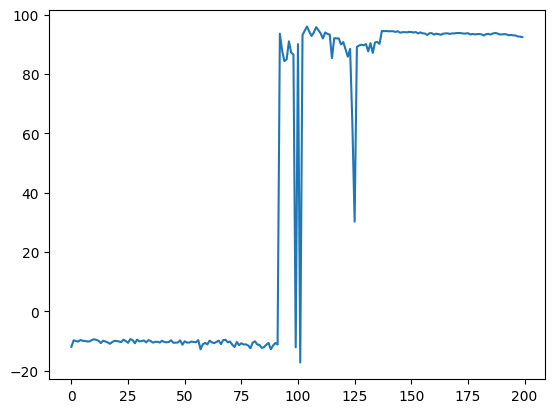

In [282]:
actor_lr = 1e-3
critic_lr = 1e-3
num_episodes = 200

device = "cpu"
env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"

env = gym.make(env_name)
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]

print(f"state space:" , env.observation_space.sample())
print(f"action space: {env.action_space}")
print(f"action bound: {action_bound}")

agent = SAC(n_state=state_dim, n_action=action_dim, n_hidden=64, action_bound=action_bound, lr_actor=actor_lr, lr_q=critic_lr, alpha = 0.02, tau=0.02,gamma=0.9999)

replay_buffer = ReplayBuffer(capacity=100000)
return_list = train_off_policy_agent(env, agent, num_episodes,replay_buffer)

%matplotlib inline
plt.plot(return_list)
plt.show()

In [283]:
action_list = test_agent(agent, env_name)

Starting observation: [-0.47260767  0.        ]
Episode finished! Total reward: 92.4246801373827


## Pendulum

state space: [-0.14252542  0.0483465  -4.0317616 ]
action space: Box(-2.0, 2.0, (1,), float32)
action bound: 2.0


###0 : 0, rb:0 :   0%|          | 0/10 [00:00<?, ?it/s]

###1 : -1436.2803897054114, rb:2000 :   0%|          | 0/10 [00:00<?, ?it/s]

###2 : -1097.252915137486, rb:4000 :   0%|          | 0/10 [00:00<?, ?it/s]

###3 : -869.9367502387164, rb:6000 :   0%|          | 0/10 [00:00<?, ?it/s]

###4 : -711.84724315785, rb:8000 :   0%|          | 0/10 [00:00<?, ?it/s]

###5 : -758.5855601435353, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###6 : -954.1222832160036, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###7 : -895.1588165329944, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###8 : -1047.8124777132768, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###9 : -972.7704958949195, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###10 : -1050.1396818020196, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###11 : -530.9562225660272, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###12 : -544.564473135783, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###13 : -142.19096843873865, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###14 : -137.00529725341457, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###15 : -132.9068080561353, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###16 : -133.1908376827155, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###17 : -139.08726191286826, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###18 : -139.56596645584355, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

###19 : -139.03761673324283, rb:10000 :   0%|          | 0/10 [00:00<?, ?it/s]

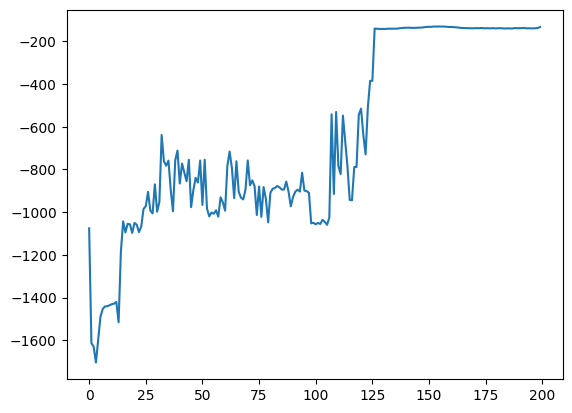

Starting observation: [ 0.6520163   0.758205   -0.46042657]
Episode finished! Total reward: -133.73133415257195


In [278]:
actor_lr = 1e-4
critic_lr = 1e-3
num_episodes = 200

device = "cpu"
env_name = "Pendulum-v1"

env = gym.make(env_name)
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]

print(f"state space:" , env.observation_space.sample())
print(f"action space: {env.action_space}")
print(f"action bound: {action_bound}")

agent = SAC(n_state=state_dim, n_action=action_dim, n_hidden=64, action_bound=action_bound, lr_actor=actor_lr, lr_q=critic_lr, alpha = 0.02, tau=0.005,gamma=0.99)

replay_buffer = ReplayBuffer(capacity=10000)
return_list = train_off_policy_agent(env, agent, num_episodes,replay_buffer)

%matplotlib inline
plt.plot(return_list)
plt.show()

action_list = test_agent(agent, env_name)